
# Clasificación con datos de **ECOBICI CDMX** (último mes disponible)

Este cuaderno adapta tu notebook de **métricas de clasificación** para usar los **últimos datos públicos mensuales** de ECOBICI CDMX.

**Qué hace:**
- Detecta automáticamente el **CSV más reciente** desde la página oficial de datos abiertos.
- Carga y limpia el dataset (tolera nombres de columnas distintos según el mes).
- Crea variables explicativas (features) y un objetivo binario **`viaje_largo`** (≥ 20 minutos).
- Entrena **Logistic Regression**, **Random Forest** y **Linear SVM**.
- Reporta **accuracy, precision, recall, F1** y muestra la **matriz de confusión** para cada modelo.

> Fuentes:
> - Página oficial de datos abiertos (lista mensual de CSV): `https://ecobici.cdmx.gob.mx/datos-abiertos/`
> - Datos en tiempo real (GBFS, no históricos): `https://gbfs.mex.lyftbikes.com/gbfs/gbfs.json`

> **Nota:** Ejecuta esto en **Google Colab** para evitar problemas de red/paquetes locales.


In [1]:

#@title Setup (librerías) — Colab listo
# Si estás en Colab, estas libs suelen estar instaladas; si no, se instalarán rápidamente.
try:
    import pandas as pd, numpy as np
    import requests, bs4
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import LinearSVC
    import matplotlib.pyplot as plt
    import seaborn as sns
except Exception:
    import sys, subprocess
    def pipi(pkg): subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
    pipi("pandas numpy requests beautifulsoup4 scikit-learn matplotlib seaborn")
    import pandas as pd, numpy as np
    import requests, bs4
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import LinearSVC
    import matplotlib.pyplot as plt
    import seaborn as sns

plt.rcParams["figure.figsize"] = (6, 5)
sns.set(font_scale=1.0)


In [8]:
#@title Detectar y descargar el **CSV más reciente** de ECOBICI (fix URLs)
import re, io, csv
from urllib.parse import urljoin
from bs4 import BeautifulSoup

OPEN_DATA_URL = "https://ecobici.cdmx.gob.mx/datos-abiertos/"
BASE = "https://ecobici.cdmx.gob.mx/"
HEADERS = {"User-Agent": "Mozilla/5.0"}

def get_latest_csv_urls(max_items=12):
    r = requests.get(OPEN_DATA_URL, timeout=30, headers=HEADERS)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, "html.parser")
    hrefs = [a.get("href") for a in soup.find_all("a") if a.get("href")]
    hrefs = [urljoin(BASE, h) for h in hrefs]  # <- convierte a absoluto
    csvs = []
    for h in hrefs:
        m = re.search(r"(\d{4})-(\d{2})\.csv$", h)
        if m:
            y, mm = int(m.group(1)), int(m.group(2))
            csvs.append((y, mm, h))
    if not csvs:
        raise RuntimeError("No se detectaron enlaces .csv en la página.")
    csvs_sorted = sorted(csvs, key=lambda t: (t[0], t[1]), reverse=True)
    return [h for _,_,h in csvs_sorted][:max_items]

def try_read_csv(url):
    r = requests.get(url, timeout=60, headers=HEADERS)
    r.raise_for_status()
    raw = r.content
    for kwargs in [{}, {"encoding": "utf-8-sig"}, {"encoding": "latin-1"}]:
        try:
            return pd.read_csv(io.BytesIO(raw), **kwargs)
        except Exception:
            pass
    sample = raw[:4000].decode("utf-8", errors="ignore")
    try:
        dialect = csv.Sniffer().sniff(sample)
        sep = dialect.delimiter
    except Exception:
        sep = ","
    return pd.read_csv(io.BytesIO(raw), sep=sep, encoding="utf-8", engine="python")

candidate_urls = get_latest_csv_urls(max_items=6)
print("Candidatos recientes:")
for u in candidate_urls:
    print("-", u)

df = None
last_err = None
for u in candidate_urls:
    try:
        print("Intentando descargar:", u)
        df = try_read_csv(u)
        latest_url = u
        break
    except Exception as e:
        print("Fallo con", u, "->", repr(e))
        last_err = e

if df is None:
    raise RuntimeError(f"No se pudo leer ninguno de los CSV candidatos. Último error: {last_err}")

print("Usando CSV:", latest_url)
print("Filas x columnas:", df.shape)
df.head()


Candidatos recientes:
- https://ecobici.cdmx.gob.mx/wp-content/uploads/2025/08/2025-07.csv
- https://ecobici.cdmx.gob.mx/wp-content/uploads/2025/07/2025-06.csv
- https://ecobici.cdmx.gob.mx/wp-content/uploads/2025/06/2025-05.csv
- https://ecobici.cdmx.gob.mx/wp-content/uploads/2025/05/2025-04.csv
- https://ecobici.cdmx.gob.mx/wp-content/uploads/2025/04/2025-03.csv
- https://ecobici.cdmx.gob.mx/wp-content/uploads/2025/03/2025-02.csv
Intentando descargar: https://ecobici.cdmx.gob.mx/wp-content/uploads/2025/08/2025-07.csv
Usando CSV: https://ecobici.cdmx.gob.mx/wp-content/uploads/2025/08/2025-07.csv
Filas x columnas: (1663896, 9)


,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_EstacionArribo,Fecha_Arribo,Hora_Arribo
0,M,30.0,4998803,173,30/06/2025,23:33:59,348,01/07/2025,00:00:11
1,M,27.0,3976669,009,30/06/2025,23:41:24,086,01/07/2025,00:00:21
2,M,43.0,8223240,576,30/06/2025,23:48:16,296,01/07/2025,00:00:24
3,M,26.0,6050157,365,30/06/2025,23:52:12,329,01/07/2025,00:00:27
4,M,23.0,5124706,144,30/06/2025,23:54:55,575,01/07/2025,00:00:46


In [9]:

#@title Estandarizar esquema (nombres de columnas pueden variar por mes)
df_raw = df.copy()

def normalize_columns(cols):
    # Pasar a minúsculas y quitar espacios
    c = [str(x).strip().lower() for x in cols]
    # Reemplazos comunes
    rep = {
        "sexo": "genero",
        "género": "genero",
        "cicloestacion origen": "estacion_origen",
        "cicloestación origen": "estacion_origen",
        "cicloestacion destino": "estacion_destino",
        "cicloestación destino": "estacion_destino",
        "id origen": "estacion_origen",
        "id destino": "estacion_destino",
        "fecha retiro": "fecha_retiro",
        "fecha arribo": "fecha_arribo",
        "hora retiro": "hora_retiro",
        "hora arribo": "hora_arribo",
        "duración": "duracion",
        "duración (min)": "duracion_min",
        "duración (seg)": "duracion_segundos",
        "duracion (min)": "duracion_min",
        "duracion (seg)": "duracion_segundos",
        "edad (años)": "edad",
    }
    c2 = [rep.get(x, x) for x in c]
    # Sustituir espacios por guiones bajos
    c2 = [x.replace(" ", "_") for x in c2]
    return c2

df.columns = normalize_columns(df.columns)

print(sorted(df.columns))
df.head()


['bici', 'ciclo_estacion_retiro', 'ciclo_estacionarribo', 'edad_usuario', 'fecha_arribo', 'fecha_retiro', 'genero_usuario', 'hora_arribo', 'hora_retiro']


,genero_usuario,edad_usuario,bici,ciclo_estacion_retiro,fecha_retiro,hora_retiro,ciclo_estacionarribo,fecha_arribo,hora_arribo
0,M,30.0,4998803,173,30/06/2025,23:33:59,348,01/07/2025,00:00:11
1,M,27.0,3976669,009,30/06/2025,23:41:24,086,01/07/2025,00:00:21
2,M,43.0,8223240,576,30/06/2025,23:48:16,296,01/07/2025,00:00:24
3,M,26.0,6050157,365,30/06/2025,23:52:12,329,01/07/2025,00:00:27
4,M,23.0,5124706,144,30/06/2025,23:54:55,575,01/07/2025,00:00:46


In [10]:

#@title Construir variables y crear **target binario** `viaje_largo` (≥ 20 min)
import numpy as np
import pandas as pd

def parse_datetime_flexible(df):
    # Intentar construir inicio/fin desde columnas disponibles
    df = df.copy()
    # Buscar columnas candidatas para fecha-hora de retiro/arribo
    # (algunos meses traen todo en una sola columna 'fecha_retiro' con hora, otros separan)
    def combine_date_time(date_col, time_col):
        s = pd.to_datetime(df[date_col].astype(str) + " " + df[time_col].astype(str), errors="coerce")
        return s

    inicio = None
    fin = None

    # Candidatas
    cols = set(df.columns)
    # Caso 1: "fecha_retiro" y "hora_retiro"
    if {"fecha_retiro","hora_retiro"}.issubset(cols):
        inicio = combine_date_time("fecha_retiro","hora_retiro")
    # Caso 2: "fecha_hora_retiro" (o similar)
    for k in ["fecha_hora_retiro","fechahora_retiro","inicio","retirada","datetime_retiro"]:
        if k in cols and inicio is None:
            inicio = pd.to_datetime(df[k], errors="coerce")
            break

    # Fin
    if {"fecha_arribo","hora_arribo"}.issubset(cols):
        fin = combine_date_time("fecha_arribo","hora_arribo")
    for k in ["fecha_hora_arribo","fechahora_arribo","fin","arribo","datetime_arribo"]:
        if k in cols and fin is None:
            fin = pd.to_datetime(df[k], errors="coerce")
            break

    # Si no hay fin, calcularemos fin = inicio + duracion
    if inicio is not None and fin is None:
        dur_s = None
        for cand in ["duracion_segundos", "duracion", "tiempo_viaje_seg", "tiempo_segundos"]:
            if cand in cols:
                dur_s = pd.to_numeric(df[cand], errors="coerce")
                break
        if dur_s is None and "duracion_min" in cols:
            dur_s = pd.to_numeric(df["duracion_min"], errors="coerce") * 60
        if dur_s is not None:
            fin = inicio + pd.to_timedelta(dur_s, unit="s")

    return inicio, fin

def get_duration_minutes(df):
    cols = set(df.columns)
    # Prioridad: segundos -> convertir a minutos
    for cand in ["duracion_segundos","tiempo_viaje_seg","tiempo_segundos"]:
        if cand in cols:
            return pd.to_numeric(df[cand], errors="coerce") / 60.0
    # Luego: minutos ya presentes
    for cand in ["duracion_min","duracion"]:
        if cand in cols:
            return pd.to_numeric(df[cand], errors="coerce")
    # Si no existe, intentar derivar desde datetime
    inicio, fin = parse_datetime_flexible(df)
    if inicio is not None and fin is not None:
        return (fin - inicio).dt.total_seconds() / 60.0
    return pd.Series(np.nan, index=df.index)

# Variables bases
df["duracion_min_calc"] = get_duration_minutes(df)
df["viaje_largo"] = (df["duracion_min_calc"] >= 20).astype(int)

# Hora y día de la semana desde inicio
inicio, fin = parse_datetime_flexible(df)
if inicio is None:
    # fallback si no hay fecha: tratar de construir desde un posible 'fecha' único
    for k in ["fecha","fecha_retiro","inicio","fechahora_retiro","fecha_hora_retiro"]:
        if k in df.columns and inicio is None:
            inicio = pd.to_datetime(df[k], errors="coerce")
            break

df["hora"] = inicio.dt.hour if inicio is not None else np.nan
df["dia_semana"] = inicio.dt.dayofweek if inicio is not None else np.nan

# Candidatos de columnas categóricas (si existen)
cat_candidates = [c for c in ["estacion_origen","estacion_destino","genero","tipo_usuario","pase"] if c in df.columns]
num_candidates = [c for c in ["hora","dia_semana","duracion_min_calc"] if c in df.columns]

print("Categóricas detectadas:", cat_candidates)
print("Numéricas detectadas:", num_candidates)

# Limpiar y filtrar
df_model = df[cat_candidates + num_candidates + ["viaje_largo"]].copy()
df_model = df_model.dropna(subset=["viaje_largo","duracion_min_calc","hora","dia_semana"])
print("Shape tras limpieza:", df_model.shape)
df_model.head()


/tmp/ipython-input-1225064617.py:11: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  s = pd.to_datetime(df[date_col].astype(str) + " " + df[time_col].astype(str), errors="coerce")
/tmp/ipython-input-1225064617.py:11: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  s = pd.to_datetime(df[date_col].astype(str) + " " + df[time_col].astype(str), errors="coerce")


Categóricas detectadas: []
Numéricas detectadas: ['hora', 'dia_semana', 'duracion_min_calc']
Shape tras limpieza: (670422, 4)


,hora,dia_semana,duracion_min_calc,viaje_largo
0,23,0,-251973.800000,0
1,23,0,-251981.050000,0
2,23,0,-251987.866667,0
3,23,0,-251991.750000,0
4,23,0,-251994.150000,0



=== Logistic Regression ===
Accuracy:  0.5206
Precision: 0.4536
Recall:    0.5340
F1-Score:  0.4905


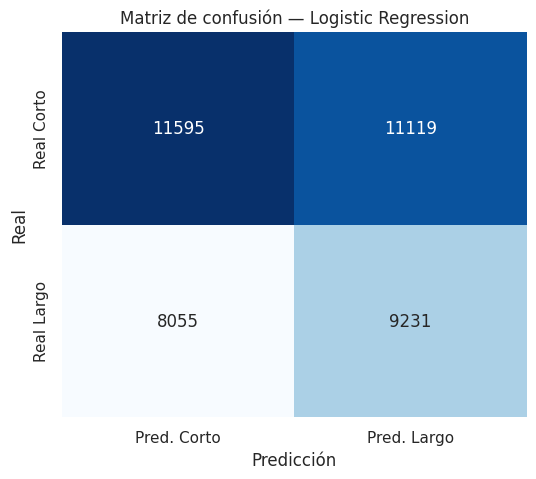


=== Random Forest ===
Accuracy:  0.5663
Precision: 0.4990
Recall:    0.8963
F1-Score:  0.6411


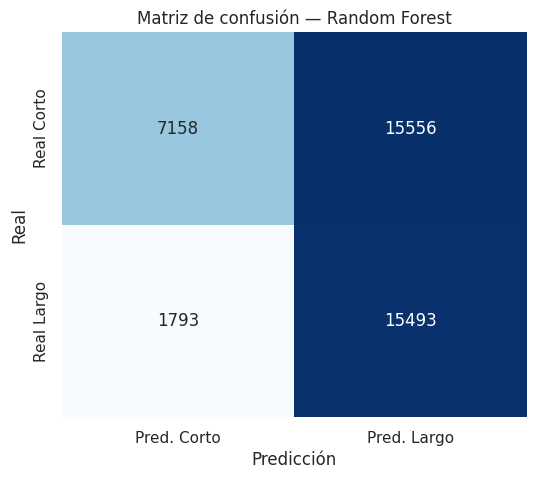


=== Linear SVM ===
Accuracy:  0.5206
Precision: 0.4536
Recall:    0.5340
F1-Score:  0.4905


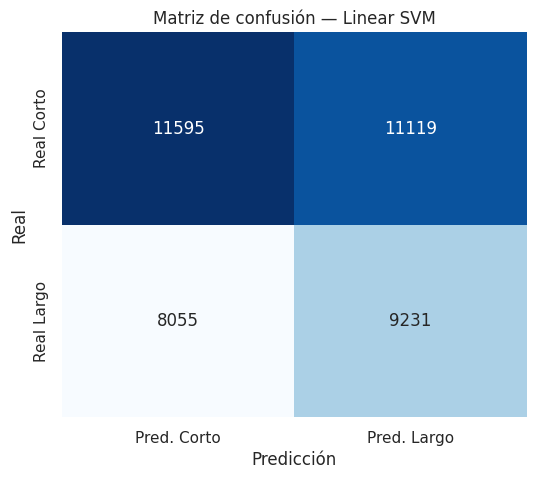

,Modelo,Accuracy,Precision,Recall,F1
1,Random Forest,0.566275,0.498985,0.896274,0.641068
0,Logistic Regression,0.520650,0.453612,0.534016,0.490541
2,Linear SVM,0.520650,0.453612,0.534016,0.490541


In [11]:

#@title Entrenar y evaluar (métricas + matriz de confusión)
from sklearn.utils.class_weight import compute_class_weight

# Muestra para evitar OOM si el mes es muy grande
MAX_ROWS = 200_000
if len(df_model) > MAX_ROWS:
    df_model = df_model.sample(MAX_ROWS, random_state=42)

X = df_model.drop(columns=["viaje_largo"])
y = df_model["viaje_largo"].astype(int)

# Columnas por tipo
categorical = [c for c in X.columns if c in ["estacion_origen","estacion_destino","genero","tipo_usuario","pase"]]
numeric = [c for c in X.columns if c in ["hora","dia_semana"]]  # no usamos duracion_min_calc como feature (fuga de info)

# Preproceso
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical),
        ("num", "passthrough", numeric)
    ]
)

# Modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced", n_jobs=None),
    "Random Forest": RandomForestClassifier(n_estimators=150, random_state=42, class_weight="balanced_subsample", n_jobs=-1),
    "Linear SVM": LinearSVC(class_weight="balanced", random_state=42)
}

def plot_confusion(cm, title):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred. Corto","Pred. Largo"],
                yticklabels=["Real Corto","Real Largo"])
    plt.title(f"Matriz de confusión — {title}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

results = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

for name, model in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("clf", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    results.append((name, acc, prec, rec, f1))

    print(f"\n=== {name} ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    plot_confusion(cm, name)

# Tabla ordenada de resultados
res_df = pd.DataFrame(results, columns=["Modelo","Accuracy","Precision","Recall","F1"]).sort_values("F1", ascending=False)
res_df



## Siguientes pasos opcionales
- Ajustar el umbral de **viaje largo** (por ejemplo, ≥ 30 minutos) y comparar resultados.
- Incluir variables adicionales si existen (edad, tipo de pase, etc.).
- Agregar validación cruzada y búsqueda de hiperparámetros (GridSearchCV).
- Cambiar el objetivo a predicción de **alta afluencia por estación** (clasificar estaciones en _alta vs baja demanda_).
